# `Read the data`

In [1]:
!pip install attention

In [2]:
import numpy as np
import pandas as pd

data_path = '/content/ara.txt'
data = pd.read_table(data_path,  names =['source', 'target', 'comments'])
data.drop('comments', axis=1, inplace=True)
data = data.iloc[:9000]
print(f"Shape of the data: {data.shape}")
data.head()

Shape of the data: (9000, 2)


,source,target
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Duck!,اخفض رأسك!
3,Duck!,اخفضي رأسك!
4,Duck!,اخفضوا رؤوسكم!


# `Dataset Cleaning`

In [3]:
import re
import string
from string import digits

In [4]:
# convert source and target text to Lowercase
data.source = data.source.apply(lambda x: x.lower())

# Remove quotes from source and target text
data.source = data.source.apply(lambda x: re.sub("'", '', x))
data.target = data.target.apply(lambda x: re.sub("'", '', x))

# create a set of all special characters
special_characters= set(string.punctuation)
# Remove all the special characters
data.source = data.source.apply(lambda x: ''.join(char for char in x if char not in special_characters))
data.target = data.target.apply(lambda x: ''.join(char for char in x if char not in special_characters))

# Remove digits from source and target sentences
num_digits = str.maketrans('','', digits)
data.source = data.source.apply(lambda x: x.translate(num_digits))
data.target = data.target.apply(lambda x: x.translate(num_digits))

# Remove extra spaces
data.source = data.source.apply(lambda x: x.strip())
data.target = data.target.apply(lambda x: x.strip())
data.source = data.source.apply(lambda x: re.sub(" +", " ", x))
data.target = data.target.apply(lambda x: re.sub(" +", " ", x))
data.source = data.source.apply(lambda x: re.sub("[^-9A-Za-z ]", "" , x))

In [5]:
def clean_text_english(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()

    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)

    return text

data.source = data.source.apply(clean_text_english)
data.source = data.source.apply(lambda x: re.sub("[.?#@%^&*()@!;:'\/!*]", "", x))

In [6]:
data.target = data.target.apply(lambda x: re.sub("[٠١٢٣٤٥٦٧٨٩۱۹۰]", "", x))
data.target = data.target.apply(lambda x: re.sub("[ـ،؛؟٫٬٠]", "", x))
data.target = data.target.apply(lambda x: re.sub("[abcdefghijklmnopqrstuvwxyz]", "", x))

# adapted from https://github.com/bakrianoo/aravec
# function to clean and normalize text
def clean_text(text):
    search = ["أ", "إ", "آ", "ة", "_", "-", "/", ".", "،", " و ", " يا ", '"', "ـ", "'", "ى", "\\", '\n', '\t', '"', '?', '؟', '!']
    replace = ["ا", "ا", "ا", "ه", " ", " ", "", "", "", " و", " يا", "", "", "", "ي", "", ' ',  ' ', ' ', ' ? ', ' ؟ ', ' ! ']
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')

    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])

    text = text.strip()

    return text

data.target = data.target.apply(clean_text)

In [7]:
def remove_diacritics(text):
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', str(text))
    return text

data.target = data.target.apply(remove_diacritics)

# `Design Encoder & Decoder, Preprocessing & Teconization`

In [9]:
# Encoder Input  :: English Sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_lines = list()
for line in data.source:
    eng_lines.append(line)

tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(eng_lines)
tokenized_eng_lines = tokenizer_eng.texts_to_sequences(eng_lines)

length_list = []
for token_seq in tokenized_eng_lines:
    length_list.append(len(token_seq))
max_eng_input_length = np.array(length_list).max()

padded_eng_lines = pad_sequences(tokenized_eng_lines, maxlen=max_eng_input_length, padding='post')

encoder_input_data = np.array(padded_eng_lines, dtype='float16')

eng_vocab_size = len(tokenizer_eng.word_index) + 1

print('English sentence max length:', max_eng_input_length)
print('Encoder input shape:', encoder_input_data.shape)
print('English vocab size:', eng_vocab_size)

English sentence max length: 9
Encoder input shape: (9000, 9)
English vocab size: 3154


In [10]:
# Decoder Input  :: Arabic Sentences

arb_lines = list()
for line in data.target:
    arb_lines.append('<START> ' + line + ' <END>')

tokenizer_arb = Tokenizer()
tokenizer_arb.fit_on_texts(arb_lines)
tokenized_arb_lines = tokenizer_arb.texts_to_sequences(arb_lines)

length_list = []
for token_seq in tokenized_arb_lines:
    length_list.append(len(token_seq))
max_arb_input_length = np.array(length_list).max()

padded_arb_lines = pad_sequences(tokenized_arb_lines, maxlen=max_arb_input_length, padding='post')

decoder_input_data = np.array(padded_arb_lines, dtype='float16')

num_arb_token = len(tokenizer_arb.word_index) + 1

print('Arabic sentence max length:', max_arb_input_length)
print('Decoder input shape:', decoder_input_data.shape)
print('Arabic vocab size:', num_arb_token)

Arabic sentence max length: 12
Decoder input shape: (9000, 12)
Arabic vocab size: 7274


In [11]:
# Decoder Output  :: Arabic Sentences -Preprocessed-

from tensorflow.keras.utils import to_categorical

decoder_output_data = list()
for token in tokenized_arb_lines:
  decoder_output_data.append(token[1:])

padded_arb_lines = pad_sequences(decoder_output_data, maxlen=max_arb_input_length, padding='post')
onehot_arb_lines = to_categorical(padded_arb_lines, num_classes=num_arb_token)

decoder_output_data = np.array(onehot_arb_lines, dtype='float16')

print('Decoder output shape:', decoder_output_data.shape)

Decoder output shape: (9000, 12, 7274)


# `Create Attention Layer`

In [12]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# `Build The model`

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.activations import softmax, relu
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import plot_model

K.clear_session()

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, 256, mask_zero=True, trainable=True)(encoder_inputs)
encoder_lstm = LSTM(128, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(num_arb_token, 256, mask_zero=True, trainable=True)(decoder_inputs)
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = Dense(num_arb_token, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │        807,424 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │      1,862,144 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, None, 128),    │        197,120 │ embedding[0][0],       │
│                           │ (None, 128), (None,    │                │ not_equal[0][0]        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 128),    │        197,120 │ embedding_1[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 128),    │         32,896 │ lstm[0][0],            │
│ (AttentionLayer)          │ (None, None, None)]    │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 256)      │              0 │ lstm_1[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 7274)     │      1,869,418 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,966,122 (18.94 MB)

 Trainable params: 4,966,122 (18.94 MB)

 Non-trainable params: 0 (0.00 B)

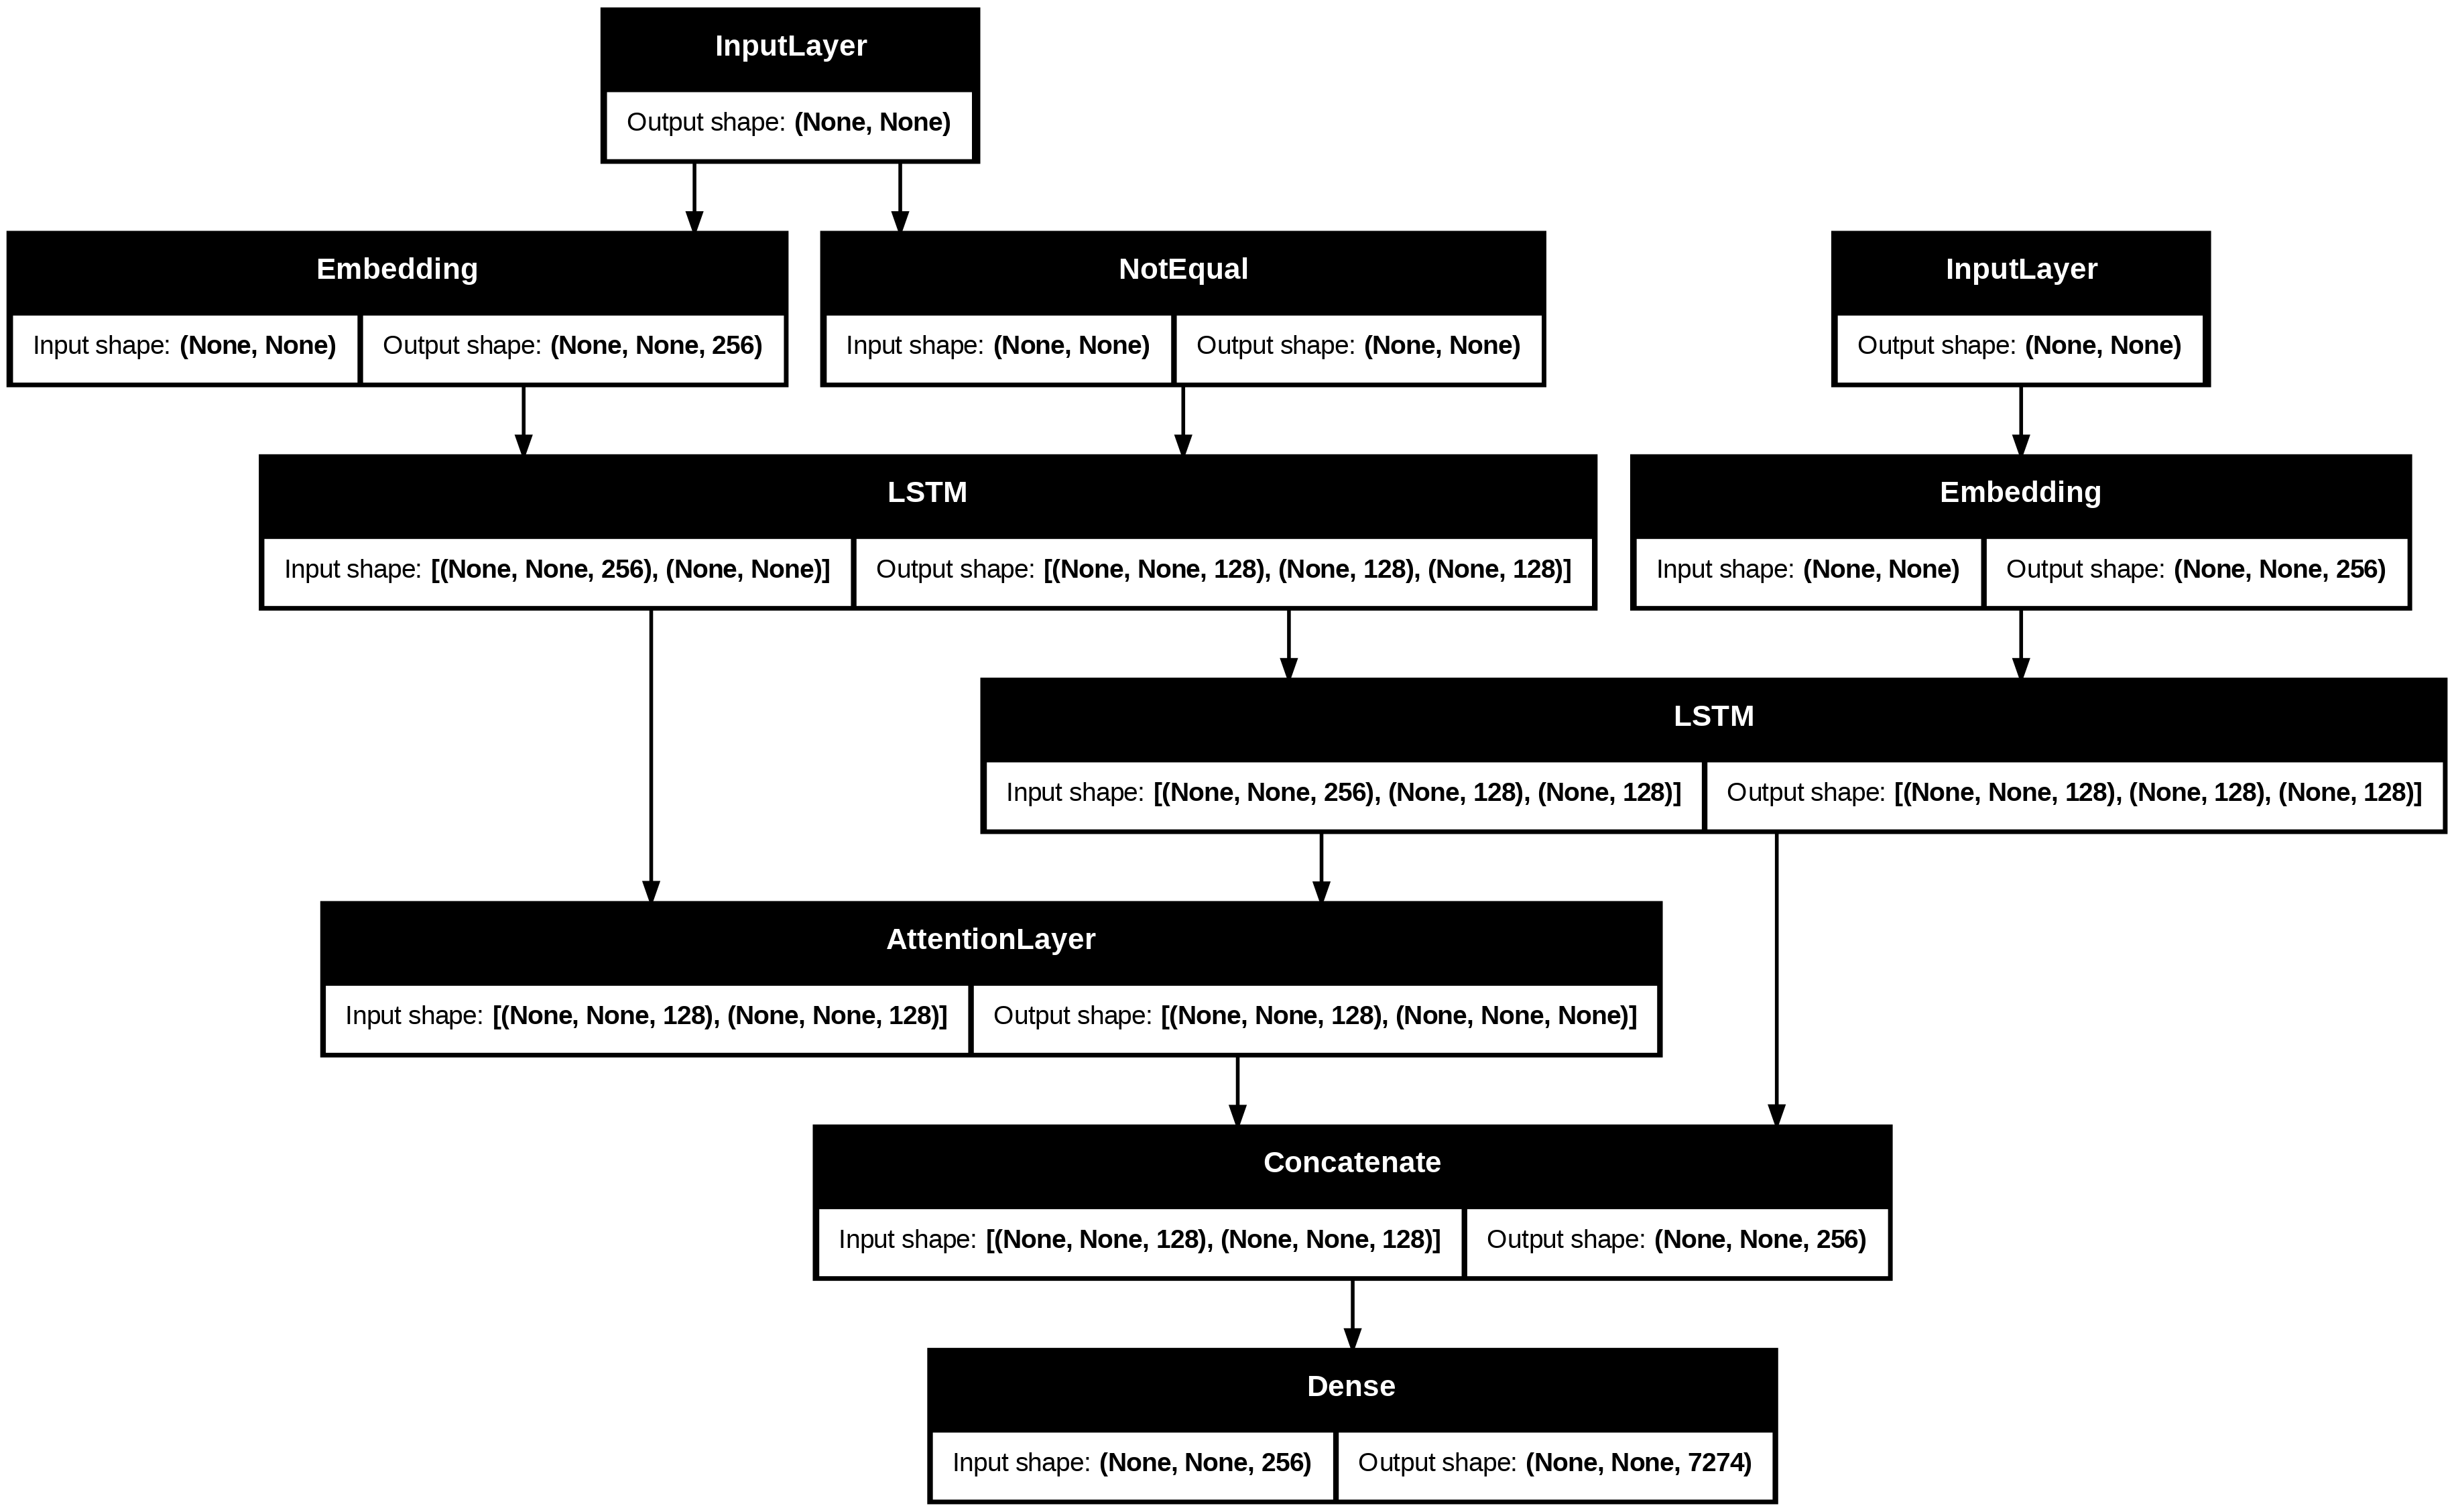

In [13]:
# Plot The Model
plot_model(model, to_file='train_model.png', show_shapes=True)

In [14]:
# Compile
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# `Train the model`

In [15]:
# Train
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_output_data,
    batch_size=16,
    epochs=200,
    validation_split=0.2
)

Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - loss: 3.4464 - val_loss: 3.0400
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - loss: 2.0768 - val_loss: 2.9876
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 2.0124 - val_loss: 2.9512
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 1.9499 - val_loss: 2.9185
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 1.9008 - val_loss: 2.8942
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - loss: 1.8357 - val_loss: 2.8662
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 1.7755 - val_loss: 2.8228
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 1.7086 - val_loss: 2.7948
Epoch 9/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 1.6681 - val_loss: 2.7817
Epoch 10/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 1.6405 - val_loss: 2.7611
Epoch 11/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 1.5767 - val_loss: 2.7447
Epoch 12/200
450/45

In [16]:
model.save('eng2arb_with_attn.keras')

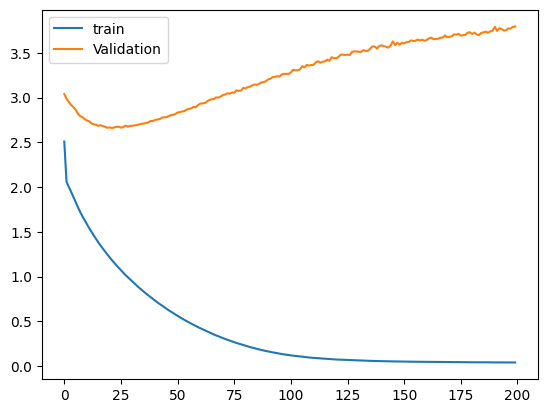

In [17]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend()
pyplot.show()

# `Inference`

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'AttentionLayer': AttentionLayer})
model_m = load_model("/content/eng2arb_with_attn.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [15]:
model_m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │        807,424 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │      1,862,144 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, None, 128),    │        197,120 │ embedding[0][0],       │
│                           │ (None, 128), (None,    │                │ not_equal[0][0]        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 128),    │        197,120 │ embedding_1[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 128),    │         32,896 │ lstm[0][0],            │
│ (AttentionLayer)          │ (None, None, None)]    │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 256)      │              0 │ lstm_1[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 7274)     │      1,869,418 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,932,246 (37.89 MB)

 Trainable params: 4,966,122 (18.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,966,124 (18.94 MB)

In [17]:
model_m.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Embedding name=embedding, built=True>,
 <Embedding name=embedding_1, built=True>,
 <LSTM name=lstm, built=True>,
 <LSTM name=lstm_1, built=True>,
 <AttentionLayer name=attention_layer, built=True>,
 <Concatenate name=concat_layer, built=True>,
 <Dense name=dense, built=True>]

In [24]:
model_m.layers[1]

<KerasTensor shape=(None, None), dtype=float32, sparse=False, name=input_layer_1>

In [46]:
def make_reference_models(model):
    encoder_inputs = model.input[0]  # input_1
    encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output  # lstm_1
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model_reference = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h_enc, state_c_enc])


    decoder_state_h = Input(shape=(128,))
    decoder_dense_c = Input(shape=(128,))
    decoder_hidden_state_input = Input(shape=(None, 128))
    decoder_states_inputs = [decoder_state_h, decoder_dense_c]

    decoder_inputs = model.input[1]  # input_2

    decoder_embedding = model.layers[3](decoder_inputs) # Embedding
    decoder_lstm = model.layers[5] # lstm_2
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]


    attn_layer = model.layers[6] # Attention Layer
    attn_out, attn_states = attn_layer([decoder_hidden_state_input, decoder_outputs])

    # Concat attention output and decoder LSTM output
    decoder_concat_input = model.layers[7]([decoder_outputs, attn_out])

    # Dense layer
    decoder_dense = model.layers[8] # Dense
    decoder_outputs = decoder_dense(decoder_concat_input)
    decoder_model_reference = Model([decoder_inputs] + [decoder_hidden_state_input] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return encoder_model_reference, decoder_model_reference

In [30]:
def str_to_tokens(sentence: str):
  words = sentence.lower().split()
  tokens_list = list()
  for word in words:
    tokens_list.append(tokenizer_eng.word_index[word])

  return pad_sequences([tokens_list], maxlen=max_eng_input_length, padding='post')

# `Test`

In [56]:
enc_model, dec_model = make_reference_models(model_m)


e_out, e_h, e_c = enc_model.predict(str_to_tokens(input('Enter an English Sentence: ')))

empty_target_seq = np.zeros((1, 1))
empty_target_seq[0, 0] = tokenizer_arb.word_index['start']
stop_condition = False
decoded_translation = ''

while not stop_condition:
  dec_outputs, h, c = dec_model.predict([empty_target_seq] + [e_out, e_h, e_c])
  sampled_word_index = np.argmax(dec_outputs[0, -1, :])
  sampled_word = None

  for word, index in tokenizer_arb.word_index.items():
    if sampled_word_index == index:
      decoded_translation += ' {}'.format(word)
      sampled_word = word

    if sampled_word == 'end' or len(decoded_translation.split()) > max_arb_input_length:
      stop_condition = True

  empty_target_seq = np.zeros((1, 1))
  empty_target_seq[0, 0] = sampled_word_index
  states_values = [h, c]

print(decoded_translation)

Enter an English Sentence: i love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 انا احبك end
